In [1]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import umap
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta, datetime
from scipy.stats import wasserstein_distance
from scipy.stats import ks_2samp

In [2]:
# Set seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Read Train Data

In [3]:
seeds = [1415, 9265, 3589, 7932, 3846, 2643, 3832, 7950, 2884, 1971]
seed_index = 9  # Change this value (0, 1, 2, etc.) for different seeds

current_seed = seeds[seed_index]

print(f"Using Preprocessing-Seed {seed_index}: {current_seed}")

Using Preprocessing-Seed 9: 1971


In [4]:
df_original = pd.read_csv(f'/Users/fabian/Downloads/MasterDegree/df_train_{current_seed}.csv')

display(df_original)
unique_vessel_groups_train = df_original['VesselGroup'].unique()
num_vessel_groups_train = df_original['VesselGroup'].nunique()
print(f"There are {num_vessel_groups_train} unique vessel groups.")
print(f"The unique vessel types groups: {unique_vessel_groups_train}")

,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
0,538005775.1,2023-05-05 21:39:27,29.747110,-95.098320,0.600000,270.200000,NAVIG8 ANDESINE,Tanker
1,538005775.1,2023-05-05 21:41:27,29.747296,-95.098903,0.938028,286.171831,NAVIG8 ANDESINE,Tanker
2,538005775.1,2023-05-05 21:43:27,29.747502,-95.099658,1.302381,283.942381,NAVIG8 ANDESINE,Tanker
3,538005775.1,2023-05-05 21:45:27,29.747463,-95.100071,0.419772,190.295437,NAVIG8 ANDESINE,Tanker
4,538005775.1,2023-05-05 21:47:27,29.748040,-95.099394,2.319033,88.353172,NAVIG8 ANDESINE,Tanker
...,...,...,...,...,...,...,...,...
200253,311263000.4,2023-09-23 10:07:50,26.087573,-80.118574,0.734690,183.877168,ADVENTURE OFTHE SEAS,Passenger
200254,311263000.4,2023-09-23 10:09:50,26.087352,-80.117670,0.471329,200.623077,ADVENTURE OFTHE SEAS,Passenger
200255,311263000.4,2023-09-23 10:11:50,26.087212,-80.117176,0.295261,159.605863,ADVENTURE OFTHE SEAS,Passenger
200256,311263000.4,2023-09-23 10:13:50,26.087236,-80.115827,0.252927,132.876412,ADVENTURE OFTHE SEAS,Passenger


There are 3 unique vessel groups.
The unique vessel types groups: ['Tanker' 'Tug' 'Passenger']


In [5]:
df_original = df_original.sort_values(by=['MMSI', 'BaseDateTime'])

In [6]:
print("Unique VesselGroups:", df_original['VesselGroup'].unique())

assert df_original.sort_values(by=['MMSI', 'BaseDateTime']).equals(df_original), "Data is not sorted by MMSI and BaseDateTime!"

print("Unique MMSI Count:", df_original['MMSI'].nunique())

Unique VesselGroups: ['Tug' 'Tanker' 'Passenger']
Unique MMSI Count: 2247


In [7]:
display(df_original)

,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
99026,205644000.6,2023-08-04 07:01:13,41.088680,-71.166330,0.100000,95.800000,SOVEREIGN,Tug
99027,205644000.6,2023-08-04 07:03:13,41.088680,-71.166330,0.100000,201.228571,SOVEREIGN,Tug
99028,205644000.6,2023-08-04 07:05:13,41.088679,-71.166331,0.100000,279.393842,SOVEREIGN,Tug
99029,205644000.6,2023-08-04 07:07:13,41.088670,-71.166340,0.100000,270.000000,SOVEREIGN,Tug
99030,205644000.6,2023-08-04 07:09:13,41.088660,-71.166330,0.100000,270.000000,SOVEREIGN,Tug
...,...,...,...,...,...,...,...,...
121578,730152433.1,2023-05-05 19:44:26,12.252520,-71.959070,0.198712,180.535254,MEDIA LUNA,Tug
121579,730152433.1,2023-05-05 19:46:26,12.252530,-71.959100,0.199664,185.418506,MEDIA LUNA,Tug
121580,730152433.1,2023-05-05 19:48:26,12.252540,-71.959110,0.200000,183.625249,MEDIA LUNA,Tug
121581,730152433.1,2023-05-05 19:50:26,12.252560,-71.959100,0.199694,175.432653,MEDIA LUNA,Tug


## Preprocessing

### Functions

In [8]:
def normalize_features(df, group_col, feature_cols):
    """
    Normalizes the numeric features using MinMaxScaler for each group.

    Parameters:
        df (pd.DataFrame): AIS dataset with group identifiers.
        group_col (str): Column representing groups (e.g., 'MMSI').
        feature_cols (list): Columns to normalize (e.g., ['LAT', 'LON', 'SOG', 'COG']).

    Returns:
        normalized_df (pd.DataFrame): DataFrame with normalized features.
        scalers (dict): Dictionary of MinMaxScalers for each group.
    """
    normalized_dfs = []
    scalers = {}

    grouped = df.groupby(group_col)

    for group_id, group_data in grouped:
        scaler = MinMaxScaler()

        normalized_features = scaler.fit_transform(group_data[feature_cols])
        scalers[group_id] = scaler

        group_data[feature_cols] = normalized_features
        normalized_dfs.append(group_data)

    normalized_df = pd.concat(normalized_dfs, axis=0)
    return normalized_df, scalers

In [9]:
def create_sequences(df, group_col, feature_cols, window_size=20, stride=10):
    """
    Creates sequences of fixed length using a sliding window approach.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        group_col (str): Column to group by (e.g., MMSI).
        feature_cols (list): Feature columns to include in the sequences.
        window_size (int): The number of rows in each sequence.
        stride (int): The step size for the sliding window.

    Returns:
        sequences (np.ndarray): Array of sequences of shape (num_sequences, window_size, num_features).
        labels (np.ndarray): Array of group identifiers for each sequence.
    """
    sequences = []
    labels = []

    grouped = df.groupby(group_col)

    for group_id, group_data in grouped:
        group_data = group_data.sort_values(by='BaseDateTime')

        features = group_data[feature_cols].values

        for start in range(0, len(features) - window_size + 1, stride):
            end = start + window_size
            sequence = features[start:end]
            if sequence.shape[0] == window_size:
                sequences.append(sequence)
                labels.append(group_id)

    return np.array(sequences), np.array(labels)

### Preprocessing Steps

In [ ]:
group_col = "MMSI"  # Column used for grouping (e.g., vessel identifier)
feature_cols = ["LAT", "LON", "SOG", "COG"]  # Feature columns to normalize and include in sequences
window_size = 40  # Length of each sliding window sequence
stride = 10  # Step size for sliding window

In [10]:
print("Starting normalization...")
normalized_df, scalers = normalize_features(df_original, group_col, feature_cols)
print("Normalization complete.")

print(f"Normalized DataFrame shape: {normalized_df.shape}")
print(f"Example of normalized data:\n{normalized_df.head()}")

print("Creating sequences...")
sequences, labels = create_sequences(normalized_df, group_col, feature_cols, window_size, stride)
print(f"Number of sequences created: {len(sequences)}")
if len(sequences) > 0:
    print(f"Shape of one sequence: {sequences[0].shape}")
    print(f"Labels (unique groups): {np.unique(labels)}")

print(f"First sequence:\n{sequences[0]}")
print(f"Corresponding label: {labels[0]}")

if "VesselGroup" in df_original.columns:
    vessel_group_sequences = {}
    vessel_groups = df_original["VesselGroup"].unique()

    for vessel_group in vessel_groups:
        print(f"Processing VesselGroup: {vessel_group}")
        group_df = normalized_df[normalized_df["VesselGroup"] == vessel_group]
        group_sequences, group_labels = create_sequences(group_df, group_col, feature_cols, window_size, stride)
        vessel_group_sequences[vessel_group] = group_sequences

        print(f"VesselGroup: {vessel_group}, Sequences: {len(group_sequences)}")

Starting normalization...
Normalization complete.
Normalized DataFrame shape: (200258, 8)
Example of normalized data:
              MMSI         BaseDateTime       LAT       LON  SOG       COG  \
99026  205644000.6  2023-08-04 07:01:13  0.750000  0.400000  0.0  0.195719   
99027  205644000.6  2023-08-04 07:03:13  0.750000  0.400000  0.0  0.656307   
99028  205644000.6  2023-08-04 07:05:13  0.728006  0.382405  0.0  0.997789   
99029  205644000.6  2023-08-04 07:07:13  0.500000  0.200000  0.0  0.956750   
99030  205644000.6  2023-08-04 07:09:13  0.250000  0.400000  0.0  0.956750   

      VesselName VesselGroup  
99026  SOVEREIGN         Tug  
99027  SOVEREIGN         Tug  
99028  SOVEREIGN         Tug  
99029  SOVEREIGN         Tug  
99030  SOVEREIGN         Tug  
Creating sequences...
Number of sequences created: 13842
Shape of one sequence: (40, 4)
Labels (unique groups): [2.10000000e+08 2.15726001e+08 2.19000034e+08 ... 6.36093142e+08
 6.36093142e+08 7.30152433e+08]
First sequence:
[[

## VAE Training

### VAE architecture

In [11]:
class SequenceVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, sequence_length):
        super(SequenceVAE, self).__init__()
        self.sequence_length = sequence_length
        self.latent_dim = latent_dim

        # Encoder: Bidirectional LSTM
        self.encoder_rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.hidden_to_mean = nn.Linear(hidden_dim * 2, latent_dim)
        self.hidden_to_logvar = nn.Linear(hidden_dim * 2, latent_dim)

        # Decoder: Unidirectional LSTM
        self.latent_to_hidden = nn.Linear(latent_dim, hidden_dim)
        self.decoder_rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.hidden_to_output = nn.Linear(hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        return mu + epsilon * std

    def encode(self, x):
        _, (hidden, _) = self.encoder_rnn(x)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=-1)
        mu = self.hidden_to_mean(hidden)
        logvar = self.hidden_to_logvar(hidden)
        return mu, logvar

    def decode(self, z):
        hidden = self.latent_to_hidden(z).unsqueeze(0)
        cell = torch.zeros_like(hidden)
        decoder_input = torch.zeros(z.size(0), self.sequence_length, hidden.size(-1)).to(z.device)
        outputs, _ = self.decoder_rnn(decoder_input, (hidden, cell))
        return self.hidden_to_output(outputs)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

### Training

In [12]:
# --- Hyperparameters ---

input_dim = 4  # LAT, LON, SOG, COG
hidden_dim = 128
latent_dim = 16
sequence_length = 40
num_epochs = 20 
learning_rate = 5e-5 
batch_size = 32  
initial_kl_weight = 0.001
kl_weight_schedule = "cosine"

trained_vaes = {}

In [13]:
def train_vae_for_vessel_group(
    vessel_group, sequences, input_dim, hidden_dim, latent_dim,
    sequence_length, num_epochs, learning_rate, batch_size, initial_kl_weight
):
    model = SequenceVAE(input_dim, hidden_dim, latent_dim, sequence_length)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    dataset = torch.tensor(sequences, dtype=torch.float32)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    kl_weight = initial_kl_weight

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in dataloader:
            optimizer.zero_grad()
            batch = batch.to(torch.float32)
            x_recon, mu, logvar = model(batch)

            recon_loss = nn.MSELoss()(x_recon, batch)

            kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1).mean()

            loss = recon_loss + kl_weight * kl_divergence
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        kl_weight = min(1.0, kl_weight + 0.05)
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}")

    print(f"Finished training VAE for VesselGroup: {vessel_group}")
    return model

In [14]:
# --- Train VAE for Each VesselGroup ---
for vessel_group, sequences in vessel_group_sequences.items():
    print(f"Training VAE for VesselGroup: {vessel_group}")
    trained_model = train_vae_for_vessel_group(
        vessel_group=vessel_group,
        sequences=sequences,
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        latent_dim=latent_dim,
        sequence_length=sequence_length,
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        batch_size=batch_size,
        initial_kl_weight=initial_kl_weight
    )
    trained_vaes[vessel_group] = trained_model

# --- Save Trained Models ---
for vessel_group, model in trained_vaes.items():
    torch.save(model.state_dict(), f"vae_{vessel_group}.pth")
    print(f"Saved model for VesselGroup: {vessel_group}")

Training VAE for VesselGroup: Tug
Epoch 1, Loss: 0.3364492124744824
Epoch 2, Loss: 0.1675545036260571
Epoch 3, Loss: 0.13102094722645624
Epoch 4, Loss: 0.12375215558069093
Epoch 5, Loss: 0.11934071092733316
Epoch 6, Loss: 0.11614846986319338
Epoch 7, Loss: 0.1142178788781166
Epoch 8, Loss: 0.11301752690758024
Epoch 9, Loss: 0.11200538501143456
Epoch 10, Loss: 0.1114184136901583
Epoch 11, Loss: 0.11101033990936619
Epoch 12, Loss: 0.11074602625199727
Epoch 13, Loss: 0.11064941079488823
Epoch 14, Loss: 0.1105279067265136
Epoch 15, Loss: 0.11041984797588417
Epoch 16, Loss: 0.11043172585112708
Epoch 17, Loss: 0.11038344986736774
Epoch 18, Loss: 0.11032093369535037
Epoch 19, Loss: 0.11034921828125205
Epoch 20, Loss: 0.11034018892262663
Finished training VAE for VesselGroup: Tug
Training VAE for VesselGroup: Tanker
Epoch 1, Loss: 0.3294732914306223
Epoch 2, Loss: 0.16291033336892724
Epoch 3, Loss: 0.1196768885012716
Epoch 4, Loss: 0.10866190674714744
Epoch 5, Loss: 0.10387039324268699
Epoch 6

## Generate synthetic data

In [15]:
window_size = 80

In [16]:
vessel_group_to_mmsis = df_original.groupby("VesselGroup")["MMSI"].unique()

scalers_by_vessel_group = {}

for vessel_group, mmsis in vessel_group_to_mmsis.items():
    group_scalers = [scalers[mmsi] for mmsi in mmsis if mmsi in scalers]
    
    if group_scalers:
        scalers_by_vessel_group[vessel_group] = group_scalers[0]

print("Available keys in scalers_by_vessel_group:", scalers_by_vessel_group.keys())

Available keys in scalers_by_vessel_group: dict_keys(['Passenger', 'Tanker', 'Tug'])


In [ ]:
def generate_unique_mmsi(existing_mmsis, num_sequences):
    """
    Generates unique MMSI values that do not overlap with existing ones.

    Parameters:
        existing_mmsis (set): Set of existing MMSI values in the original dataset.
        num_sequences (int): Number of new unique MMSI values needed.

    Returns:
        new_mmsis (list): List of unique MMSI values.
    """
    new_mmsis = []
    next_mmsi = max(existing_mmsis) + 1 if existing_mmsis else 1

    while len(new_mmsis) < num_sequences:
        if next_mmsi not in existing_mmsis:
            new_mmsis.append(next_mmsi)
        next_mmsi += 1

    return new_mmsis

In [ ]:
def rescale_features_by_vessel_group(synthetic_df, scalers, feature_cols):
    """
    Rescales synthetic features back to their original scale using the appropriate scaler for each VesselGroup.

    Parameters:
        synthetic_df (pd.DataFrame): Synthetic dataset with a 'VesselGroup' column.
        scalers (dict): Dictionary of MinMaxScalers for each vessel group (keys are VesselGroups).
        feature_cols (list): List of feature columns to rescale.

    Returns:
        synthetic_df (pd.DataFrame): Rescaled synthetic dataset.
    """
    rescaled_data = []

    for vessel_group, group_data in synthetic_df.groupby("VesselGroup"):
        if vessel_group not in scalers:
            raise ValueError(f"Scaler not found for VesselGroup: {vessel_group}")

        scaler = scalers[vessel_group]
        group_data[feature_cols] = scaler.inverse_transform(group_data[feature_cols])
        rescaled_data.append(group_data)

    rescaled_df = pd.concat(rescaled_data, axis=0)
    return rescaled_df

In [ ]:
def generate_synthetic_data(model, num_sequences, sequence_length, input_dim, vessel_group, start_time, time_interval, unique_mmsis):
    """
    Generates synthetic data using a trained VAE and adds metadata.

    Parameters:
        model (torch.nn.Module): Trained VAE model.
        num_sequences (int): Number of synthetic sequences to generate.
        sequence_length (int): Length of each sequence.
        input_dim (int): Number of features in each sequence.
        vessel_group (str): VesselGroup name for the synthetic data.
        start_time (datetime): Starting time for BaseDateTime.
        time_interval (timedelta): Time interval for BaseDateTime.
        unique_mmsis (list): List of unique MMSI values for the sequences.

    Returns:
        synthetic_df (pd.DataFrame): DataFrame with synthetic data and metadata.
    """
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_sequences, model.latent_dim)
        synthetic_sequences = model.decode(z).numpy()

    synthetic_data = synthetic_sequences.reshape(-1, input_dim)

    synthetic_df = pd.DataFrame(synthetic_data, columns=["LAT", "LON", "SOG", "COG"])
    synthetic_df["VesselGroup"] = vessel_group
    synthetic_df["BaseDateTime"] = [
        (start_time + i * time_interval).strftime('%Y-%m-%d %H:%M:%S') for i in range(len(synthetic_df))
    ]
    synthetic_df["MMSI"] = np.repeat(unique_mmsis, sequence_length)[:len(synthetic_df)]
    synthetic_df["VesselName"] = f"Augmented_{vessel_group}"

    return synthetic_df

In [17]:
# Parameters
augmentation_sizes = [50000, 100000, 150000, 200000]
start_time = datetime.now()
time_interval = timedelta(minutes=2)
feature_cols = ["LAT", "LON", "SOG", "COG"]
augmented_datasets = []
quantitative_results = []

existing_mmsis = set(df_original["MMSI"].unique())

for augment_size in augmentation_sizes:
    print(f"Generating {augment_size} augmented rows...")
    augmented_data = []
    
    rows_per_group = augment_size // len(trained_vaes)
    sequences_per_group = 2 * rows_per_group // window_size

    for vessel_group, model in trained_vaes.items():
        print(f"Generating synthetic data for {vessel_group}...")
        
        unique_mmsis = generate_unique_mmsi(existing_mmsis, sequences_per_group)
        existing_mmsis.update(unique_mmsis)
        
        synthetic_df = generate_synthetic_data(
            model=model,
            num_sequences=sequences_per_group,
            sequence_length=window_size,
            input_dim=len(feature_cols),
            vessel_group=vessel_group,
            start_time=start_time,
            time_interval=time_interval,
            unique_mmsis=unique_mmsis,
        )
        
        synthetic_df = rescale_features_by_vessel_group(synthetic_df, scalers_by_vessel_group, feature_cols)
        
        start_time += timedelta(minutes=2 * len(synthetic_df))
        augmented_data.append(synthetic_df)
    
    augmented_data = pd.concat(augmented_data).reset_index(drop=True)
    display(augmented_data)

    augmented_data = augmented_data.iloc[:augment_size]
    print(f"Augmented data size: {len(augmented_data)} rows.")
    
    combined_data = pd.concat([df_original, augmented_data]).reset_index(drop=True)

    """
    # Apply UMAP
    print("Applying UMAP for dimensionality reduction...")
    umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15)
    X_combined = combined_data[feature_cols].fillna(0)  # Handle missing values if any
    X_umap = umap_reducer.fit_transform(X_combined)
    combined_data['umap_dim1'], combined_data['umap_dim2'] = X_umap[:, 0], X_umap[:, 1]

    # Compute Wasserstein Distance
    combined_data['source'] = np.where(combined_data['MMSI'].isin(df_original['MMSI']), 'Original', 'Augmented')
    df_original_umap = combined_data[combined_data['source'] == 'Original']
    df_augmented_umap = combined_data[combined_data['source'] == 'Augmented']
    wd_dim1 = wasserstein_distance(df_original_umap['umap_dim1'], df_augmented_umap['umap_dim1'])
    wd_dim2 = wasserstein_distance(df_original_umap['umap_dim2'], df_augmented_umap['umap_dim2'])
    print(f"Wasserstein Distance (Dimension 1): {wd_dim1}")
    print(f"Wasserstein Distance (Dimension 2): {wd_dim2}")
    quantitative_results.append({
        'augmentation_size': augment_size,
        'wasserstein_dim1': wd_dim1,
        'wasserstein_dim2': wd_dim2
    })

    # Plot UMAP visualization
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=combined_data,
        x='umap_dim1',
        y='umap_dim2',
        hue='source',
        alpha=0.5
    )
    plt.title(f"UMAP Visualization: Original vs Augmented (Rows: {augment_size})")
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.legend()
    plt.grid(True)
    plt.show()
    """

    augmented_datasets.append(combined_data)
    display(combined_data)


    base_dir = f'/Users/fabian/Downloads/MasterDegree/vae/vae{current_seed}'
    file_name = f'df_vae_{augment_size}.csv'
    file_path = os.path.join(base_dir, file_name)

    os.makedirs(base_dir, exist_ok=True)

    combined_data.to_csv(file_path, index=False)

    print(f"Saved combined dataset with approximately {augment_size} augmented rows to '{file_name}'.")

quantitative_df = pd.DataFrame(quantitative_results)
print("\nQuantitative Results:")
display(quantitative_df)

Generating 50000 augmented rows...
Generating synthetic data for Tug...
Generating synthetic data for Tanker...
Generating synthetic data for Passenger...


,LAT,LON,SOG,COG,VesselGroup,BaseDateTime,MMSI,VesselName
0,41.088669,-71.166328,0.473733,164.975098,Tug,2025-01-07 20:50:04,730152434.1,Augmented_Tug
1,41.088669,-71.166328,0.492663,165.340103,Tug,2025-01-07 20:52:04,730152434.1,Augmented_Tug
2,41.088669,-71.166328,0.504918,167.167328,Tug,2025-01-07 20:54:04,730152434.1,Augmented_Tug
3,41.088669,-71.166328,0.511391,168.168823,Tug,2025-01-07 20:56:04,730152434.1,Augmented_Tug
4,41.088669,-71.166328,0.513130,168.171463,Tug,2025-01-07 20:58:04,730152434.1,Augmented_Tug
...,...,...,...,...,...,...,...,...
49915,19.630495,-156.002335,1.766305,180.693756,Passenger,2025-03-18 04:40:04,730153473.1,Augmented_Passenger
49916,19.630495,-156.002335,1.766305,180.693710,Passenger,2025-03-18 04:42:04,730153473.1,Augmented_Passenger
49917,19.630495,-156.002335,1.766304,180.693680,Passenger,2025-03-18 04:44:04,730153473.1,Augmented_Passenger
49918,19.630495,-156.002335,1.766304,180.693680,Passenger,2025-03-18 04:46:04,730153473.1,Augmented_Passenger


Augmented data size: 49920 rows.


,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
0,205644000.6,2023-08-04 07:01:13,41.088680,-71.166330,0.100000,95.800000,SOVEREIGN,Tug
1,205644000.6,2023-08-04 07:03:13,41.088680,-71.166330,0.100000,201.228571,SOVEREIGN,Tug
2,205644000.6,2023-08-04 07:05:13,41.088679,-71.166331,0.100000,279.393842,SOVEREIGN,Tug
3,205644000.6,2023-08-04 07:07:13,41.088670,-71.166340,0.100000,270.000000,SOVEREIGN,Tug
4,205644000.6,2023-08-04 07:09:13,41.088660,-71.166330,0.100000,270.000000,SOVEREIGN,Tug
...,...,...,...,...,...,...,...,...
250173,730153473.1,2025-03-18 04:40:04,19.630495,-156.002335,1.766305,180.693756,Augmented_Passenger,Passenger
250174,730153473.1,2025-03-18 04:42:04,19.630495,-156.002335,1.766305,180.693710,Augmented_Passenger,Passenger
250175,730153473.1,2025-03-18 04:44:04,19.630495,-156.002335,1.766304,180.693680,Augmented_Passenger,Passenger
250176,730153473.1,2025-03-18 04:46:04,19.630495,-156.002335,1.766304,180.693680,Augmented_Passenger,Passenger


Saved combined dataset with approximately 50000 augmented rows to 'df_vae_50000.csv'.
Generating 100000 augmented rows...
Generating synthetic data for Tug...
Generating synthetic data for Tanker...
Generating synthetic data for Passenger...


,LAT,LON,SOG,COG,VesselGroup,BaseDateTime,MMSI,VesselName
0,41.088669,-71.166328,0.494324,152.070343,Tug,2025-03-18 04:50:04,730153682.1,Augmented_Tug
1,41.088669,-71.166328,0.497418,156.519775,Tug,2025-03-18 04:52:04,730153682.1,Augmented_Tug
2,41.088669,-71.166328,0.502683,160.361633,Tug,2025-03-18 04:54:04,730153682.1,Augmented_Tug
3,41.088669,-71.166328,0.505442,162.672241,Tug,2025-03-18 04:56:04,730153682.1,Augmented_Tug
4,41.088669,-71.166328,0.505983,163.825562,Tug,2025-03-18 04:58:04,730153682.1,Augmented_Tug
...,...,...,...,...,...,...,...,...
99955,19.630495,-156.002335,1.766305,180.693756,Passenger,2025-08-04 00:40:04,730155764.1,Augmented_Passenger
99956,19.630495,-156.002335,1.766306,180.693756,Passenger,2025-08-04 00:42:04,730155764.1,Augmented_Passenger
99957,19.630495,-156.002335,1.766305,180.693710,Passenger,2025-08-04 00:44:04,730155764.1,Augmented_Passenger
99958,19.630495,-156.002335,1.766305,180.693680,Passenger,2025-08-04 00:46:04,730155764.1,Augmented_Passenger


Augmented data size: 99960 rows.


,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
0,205644000.6,2023-08-04 07:01:13,41.088680,-71.166330,0.100000,95.800000,SOVEREIGN,Tug
1,205644000.6,2023-08-04 07:03:13,41.088680,-71.166330,0.100000,201.228571,SOVEREIGN,Tug
2,205644000.6,2023-08-04 07:05:13,41.088679,-71.166331,0.100000,279.393842,SOVEREIGN,Tug
3,205644000.6,2023-08-04 07:07:13,41.088670,-71.166340,0.100000,270.000000,SOVEREIGN,Tug
4,205644000.6,2023-08-04 07:09:13,41.088660,-71.166330,0.100000,270.000000,SOVEREIGN,Tug
...,...,...,...,...,...,...,...,...
300213,730155764.1,2025-08-04 00:40:04,19.630495,-156.002335,1.766305,180.693756,Augmented_Passenger,Passenger
300214,730155764.1,2025-08-04 00:42:04,19.630495,-156.002335,1.766306,180.693756,Augmented_Passenger,Passenger
300215,730155764.1,2025-08-04 00:44:04,19.630495,-156.002335,1.766305,180.693710,Augmented_Passenger,Passenger
300216,730155764.1,2025-08-04 00:46:04,19.630495,-156.002335,1.766305,180.693680,Augmented_Passenger,Passenger


Saved combined dataset with approximately 100000 augmented rows to 'df_vae_100000.csv'.
Generating 150000 augmented rows...
Generating synthetic data for Tug...
Generating synthetic data for Tanker...
Generating synthetic data for Passenger...


,LAT,LON,SOG,COG,VesselGroup,BaseDateTime,MMSI,VesselName
0,41.088669,-71.166328,0.450036,164.791306,Tug,2025-08-04 00:50:04,730156181.1,Augmented_Tug
1,41.088669,-71.166328,0.471670,162.826431,Tug,2025-08-04 00:52:04,730156181.1,Augmented_Tug
2,41.088669,-71.166328,0.487403,164.769806,Tug,2025-08-04 00:54:04,730156181.1,Augmented_Tug
3,41.088669,-71.166328,0.495774,165.504623,Tug,2025-08-04 00:56:04,730156181.1,Augmented_Tug
4,41.088669,-71.166328,0.498630,165.317490,Tug,2025-08-04 00:58:04,730156181.1,Augmented_Tug
...,...,...,...,...,...,...,...,...
149995,19.630495,-156.002335,1.766304,180.693680,Passenger,2026-02-28 08:40:04,730159305.1,Augmented_Passenger
149996,19.630495,-156.002335,1.766304,180.693710,Passenger,2026-02-28 08:42:04,730159305.1,Augmented_Passenger
149997,19.630495,-156.002335,1.766304,180.693710,Passenger,2026-02-28 08:44:04,730159305.1,Augmented_Passenger
149998,19.630495,-156.002335,1.766304,180.693680,Passenger,2026-02-28 08:46:04,730159305.1,Augmented_Passenger


Augmented data size: 150000 rows.


,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
0,205644000.6,2023-08-04 07:01:13,41.088680,-71.166330,0.100000,95.800000,SOVEREIGN,Tug
1,205644000.6,2023-08-04 07:03:13,41.088680,-71.166330,0.100000,201.228571,SOVEREIGN,Tug
2,205644000.6,2023-08-04 07:05:13,41.088679,-71.166331,0.100000,279.393842,SOVEREIGN,Tug
3,205644000.6,2023-08-04 07:07:13,41.088670,-71.166340,0.100000,270.000000,SOVEREIGN,Tug
4,205644000.6,2023-08-04 07:09:13,41.088660,-71.166330,0.100000,270.000000,SOVEREIGN,Tug
...,...,...,...,...,...,...,...,...
350253,730159305.1,2026-02-28 08:40:04,19.630495,-156.002335,1.766304,180.693680,Augmented_Passenger,Passenger
350254,730159305.1,2026-02-28 08:42:04,19.630495,-156.002335,1.766304,180.693710,Augmented_Passenger,Passenger
350255,730159305.1,2026-02-28 08:44:04,19.630495,-156.002335,1.766304,180.693710,Augmented_Passenger,Passenger
350256,730159305.1,2026-02-28 08:46:04,19.630495,-156.002335,1.766304,180.693680,Augmented_Passenger,Passenger


Saved combined dataset with approximately 150000 augmented rows to 'df_vae_150000.csv'.
Generating 200000 augmented rows...
Generating synthetic data for Tug...
Generating synthetic data for Tanker...
Generating synthetic data for Passenger...


,LAT,LON,SOG,COG,VesselGroup,BaseDateTime,MMSI,VesselName
0,41.088669,-71.166328,0.464212,157.327637,Tug,2026-02-28 08:50:04,730159931.1,Augmented_Tug
1,41.088669,-71.166328,0.473055,157.686035,Tug,2026-02-28 08:52:04,730159931.1,Augmented_Tug
2,41.088669,-71.166328,0.485814,160.690384,Tug,2026-02-28 08:54:04,730159931.1,Augmented_Tug
3,41.088669,-71.166328,0.492492,162.583282,Tug,2026-02-28 08:56:04,730159931.1,Augmented_Tug
4,41.088669,-71.166328,0.495826,163.555969,Tug,2026-02-28 08:58:04,730159931.1,Augmented_Tug
...,...,...,...,...,...,...,...,...
199915,19.630495,-156.002335,1.766306,180.693756,Passenger,2026-12-03 00:40:04,730164095.1,Augmented_Passenger
199916,19.630495,-156.002335,1.766305,180.693710,Passenger,2026-12-03 00:42:04,730164095.1,Augmented_Passenger
199917,19.630495,-156.002335,1.766306,180.693710,Passenger,2026-12-03 00:44:04,730164095.1,Augmented_Passenger
199918,19.630495,-156.002335,1.766305,180.693710,Passenger,2026-12-03 00:46:04,730164095.1,Augmented_Passenger


Augmented data size: 199920 rows.


,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
0,205644000.6,2023-08-04 07:01:13,41.088680,-71.166330,0.100000,95.800000,SOVEREIGN,Tug
1,205644000.6,2023-08-04 07:03:13,41.088680,-71.166330,0.100000,201.228571,SOVEREIGN,Tug
2,205644000.6,2023-08-04 07:05:13,41.088679,-71.166331,0.100000,279.393842,SOVEREIGN,Tug
3,205644000.6,2023-08-04 07:07:13,41.088670,-71.166340,0.100000,270.000000,SOVEREIGN,Tug
4,205644000.6,2023-08-04 07:09:13,41.088660,-71.166330,0.100000,270.000000,SOVEREIGN,Tug
...,...,...,...,...,...,...,...,...
400173,730164095.1,2026-12-03 00:40:04,19.630495,-156.002335,1.766306,180.693756,Augmented_Passenger,Passenger
400174,730164095.1,2026-12-03 00:42:04,19.630495,-156.002335,1.766305,180.693710,Augmented_Passenger,Passenger
400175,730164095.1,2026-12-03 00:44:04,19.630495,-156.002335,1.766306,180.693710,Augmented_Passenger,Passenger
400176,730164095.1,2026-12-03 00:46:04,19.630495,-156.002335,1.766305,180.693710,Augmented_Passenger,Passenger


Saved combined dataset with approximately 200000 augmented rows to 'df_vae_200000.csv'.

Quantitative Results:


""


In [18]:
def evaluate_synthetic_data(original_data, synthetic_data, feature_cols):
    """
    Evaluates the quality of synthetic data by comparing distributions and correlations.

    Parameters:
        original_data (pd.DataFrame): Original dataset.
        synthetic_data (pd.DataFrame): Synthetic dataset.
        feature_cols (list): List of feature columns to compare.

    Returns:
        None
    """
    print("\nEvaluating synthetic data quality...")
    
    print("\n### Distribution Comparison ###")
    for feature in feature_cols:
        original_mean, original_std = original_data[feature].mean(), original_data[feature].std()
        synthetic_mean, synthetic_std = synthetic_data[feature].mean(), synthetic_data[feature].std()
        
        ks_stat, ks_pvalue = ks_2samp(original_data[feature], synthetic_data[feature])
        
        print(f"Feature: {feature}")
        print(f"  Original - Mean: {original_mean:.4f}, Std: {original_std:.4f}")
        print(f"  Synthetic - Mean: {synthetic_mean:.4f}, Std: {synthetic_std:.4f}")
        print(f"  Kolmogorov-Smirnov Test - D statistic: {ks_stat:.4f}, p-value: {ks_pvalue:.4f}")
        print()

        plt.figure(figsize=(8, 4))
        sns.histplot(original_data[feature], kde=True, label='Original', color='blue', stat='density', alpha=0.6)
        sns.histplot(synthetic_data[feature], kde=True, label='Synthetic', color='orange', stat='density', alpha=0.6)
        plt.title(f"Distribution of {feature}")
        plt.legend()
        plt.show()
    
    print("\n### Correlation Comparison ###")
    original_corr = original_data[feature_cols].corr()
    synthetic_corr = synthetic_data[feature_cols].corr()
    
    print("Original Data Correlation Matrix:")
    print(original_corr)
    print("\nSynthetic Data Correlation Matrix:")
    print(synthetic_corr)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    sns.heatmap(original_corr, annot=True, fmt=".2f", ax=axes[0], cmap="coolwarm")
    axes[0].set_title("Original Data Correlation")
    sns.heatmap(synthetic_corr, annot=True, fmt=".2f", ax=axes[1], cmap="coolwarm")
    axes[1].set_title("Synthetic Data Correlation")
    plt.show()
    
    print("\n### PCA Analysis ###")
    from sklearn.decomposition import PCA
    
    pca = PCA(n_components=2)
    original_pca = pca.fit_transform(original_data[feature_cols])
    synthetic_pca = pca.transform(synthetic_data[feature_cols])
    
    plt.figure(figsize=(8, 6))
    plt.scatter(original_pca[:, 0], original_pca[:, 1], label="Original", alpha=0.5, color="blue")
    plt.scatter(synthetic_pca[:, 0], synthetic_pca[:, 1], label="Synthetic", alpha=0.5, color="orange")
    plt.title("PCA: Original vs. Synthetic Data")
    plt.legend()
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()


Evaluating synthetic data quality...

### Distribution Comparison ###
Feature: LAT
  Original - Mean: 34.2590, Std: 7.9955
  Synthetic - Mean: 33.7335, Std: 9.9779
  Kolmogorov-Smirnov Test - D statistic: 0.3857, p-value: 0.0000



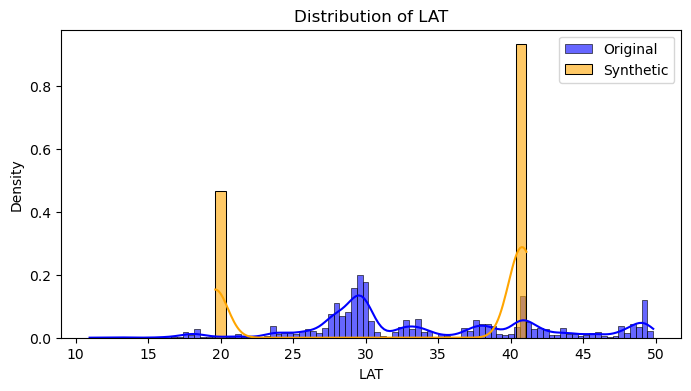

Feature: LON
  Original - Mean: -95.0742, Std: 20.3013
  Synthetic - Mean: -100.2755, Std: 39.4218
  Kolmogorov-Smirnov Test - D statistic: 0.5736, p-value: 0.0000



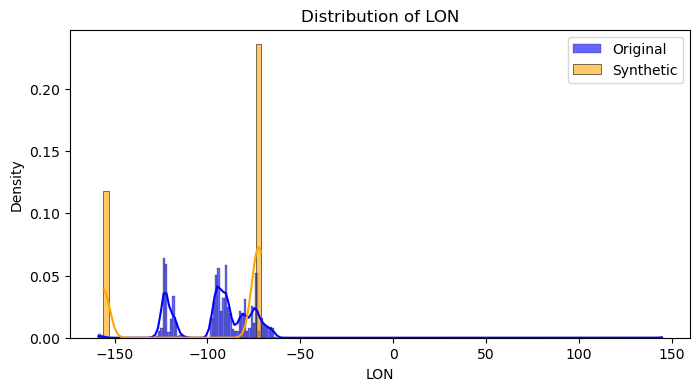

Feature: SOG
  Original - Mean: 7.1412, Std: 8.6894
  Synthetic - Mean: 0.8063, Std: 0.6930
  Kolmogorov-Smirnov Test - D statistic: 0.6628, p-value: 0.0000



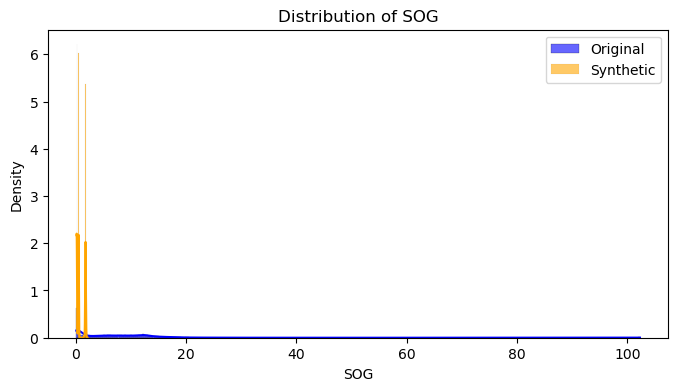

Feature: COG
  Original - Mean: 187.9609, Std: 104.6518
  Synthetic - Mean: 193.7972, Std: 31.7033
  Kolmogorov-Smirnov Test - D statistic: 0.4218, p-value: 0.0000



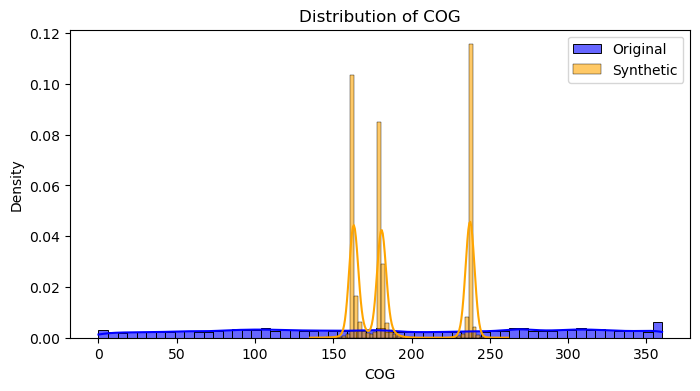


### Correlation Comparison ###
Original Data Correlation Matrix:
          LAT       LON       SOG       COG
LAT  1.000000 -0.301391 -0.029502 -0.038647
LON -0.301391  1.000000  0.031206 -0.007488
SOG -0.029502  0.031206  1.000000  0.055050
COG -0.038647 -0.007488  0.055050  1.000000

Synthetic Data Correlation Matrix:
          LAT       LON       SOG       COG
LAT  1.000000  1.000000 -0.973620  0.265298
LON  1.000000  1.000000 -0.973408  0.264392
SOG -0.973620 -0.973408  1.000000 -0.471949
COG  0.265298  0.264392 -0.471949  1.000000


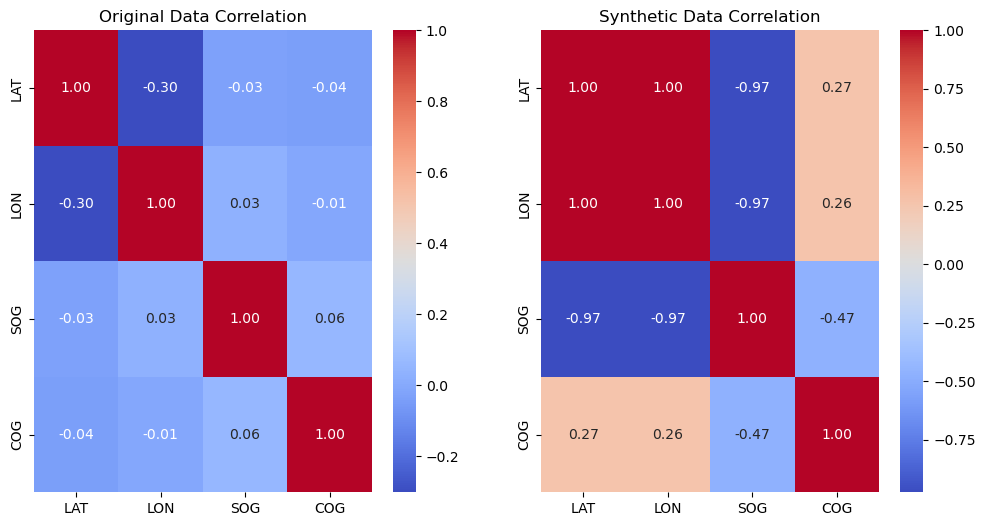


### PCA Analysis ###


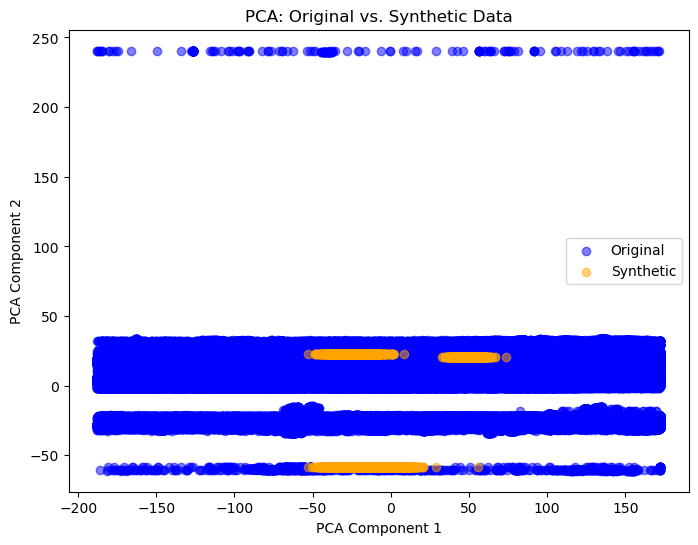

In [19]:
last_synthetic_data = augmented_data
evaluate_synthetic_data(df_original, last_synthetic_data, ["LAT", "LON", "SOG", "COG"])